### *Code modified from https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_model*
### *Modified by Soundpulse :D*

## TODO:

- Use Grid Search for better hyperparameters
- transform the predicted data back to the original axis
- Ensembling with other predicting architectures (Expotential Smoothing, Regression, KNN Regressor etc.)
- Extra: Dimensionality Reduction on the dataset? 🤔

In [1]:
import pandas as pd
import requests
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import GridSearchCV
import sklearn

np.random.seed(42)
tf.random.set_seed(42)

Using TensorFlow backend.


In [2]:
# Data Science Accelerator Credentials 
RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" 
access_token = 'tUn7ZD2ZsW9jKiFpoS56ua2g3hnLaUEE8A1nE6cQ'

In [3]:
ric = 'JPY=' # put the RIC of the asset you want to retrieve data

requestData = {
    'interval': 'P1D',
    'start': '2016-11-01',
    'end': '2019-06-30',
    #"fields": 'TRDPRC_1' # Uncomment this line if you wish to specify which fields to be returned, e.g. TRDPRC_1 is an available field for AAPL.O
};

In [4]:
def get_data_request(url, requestData):
    """
    HTTP GET request to Refinitiv API
    
    There is more information in the returned dict (i.e. json) object from the API, we store the data in a DataFrame.
    
    :param url: str, the url of the API endpoint
    :param requestData: dict, contains user-defined variables
    :return: DataFrame, containing the historical pricing data. 
        Returned field list order and content can vary depending on the exchange / instrument.
        Therefore returned data must be treated using appropriate parsing techniques.
    """
    dResp = requests.get(url, headers = {'X-api-key': access_token}, params = requestData);       

    if dResp.status_code != 200:
        raise ValueError("Unable to get data. Code %s, Message: %s" % (dResp.status_code, dResp.text));
    else:
        print("Data access successful")
        jResp = json.loads(dResp.text);
        data = jResp[0]['data']
        headers = jResp[0]['headers']  
        names = [headers[x]['name'] for x in range(len(headers))]
        df = pd.DataFrame(data, columns=names )
        return df
    
resource_endpoint_ric = RESOURCE_ENDPOINT + ric  
df = get_data_request(resource_endpoint_ric, requestData)

Data access successful


In [ ]:
print(df.shape)
df.head()

(694, 23)


,DATE,BID,ASK,BID_HIGH_1,BID_LOW_1,OPEN_BID,MID_PRICE,NUM_BIDS,ASK_LOW_1,ASK_HIGH_1,...,ASIACL_BID,EUROP_BID,EURHI_BID,EURLO_BID,EURCL_BID,AMEROP_BID,AMERHI_BID,AMERLO_BID,AMERCL_BID,OPEN_ASK
0,2019-06-28,107.88,107.91,107.93,107.55,107.78,107.895,91894.0,107.57,107.96,...,107.64,107.63,107.85,107.58,107.84,107.66,107.93,107.62,107.88,107.81
1,2019-06-27,107.78,107.81,108.15,107.63,107.78,107.795,94057.0,107.66,108.18,...,108.04,108.05,108.15,107.66,107.72,107.82,107.94,107.66,107.78,107.81
2,2019-06-26,107.77,107.80,107.84,107.08,107.18,107.785,81259.0,107.11,107.87,...,107.46,107.47,107.75,107.35,107.63,107.67,107.84,107.58,107.77,107.21
3,2019-06-25,107.17,107.20,107.40,106.77,107.29,107.185,98267.0,106.79,107.43,...,107.03,106.81,107.14,106.80,106.91,106.97,107.39,106.82,107.17,107.30
4,2019-06-24,107.28,107.31,107.53,107.23,107.39,107.295,86297.0,107.26,107.55,...,107.39,107.42,107.53,107.23,107.35,107.29,107.53,107.23,107.28,107.40


In [ ]:
df['DATE'] = pd.to_datetime(df['DATE']).astype('O')
df.set_index('DATE', inplace=True)

df['dBid']= df.BID_HIGH_1 - df.BID_LOW_1
df['AMER_dBid']= df.AMERHI_BID - df.AMERLO_BID
df['ASIA_dBid']= df.ASIAHI_BID - df.ASIALO_BID
df['EUR_dBid']= df.EURHI_BID - df.EURLO_BID

df['OTC'] = df.AMERCL_BID.shift() - df.AMEROP_BID
df['AMER_OTC'] = df.AMERCL_BID.shift() - df.AMEROP_BID
df['ASIA_OTC'] = df.ASIACL_BID.shift() - df.ASIAOP_BID
df['EUR_OTC'] = df.EURCL_BID.shift() - df.EUROP_BID

df['FT'] = df.AMERCL_BID - df.AMEROP_BID
df['AMER_FT'] = df.AMERCL_BID - df.AMEROP_BID
df['ASIA_FT'] = df.ASIACL_BID - df.ASIAOP_BID
df['EUR_FT'] = df.EURCL_BID - df.EUROP_BID


In [ ]:
# Drop Ask
df = df.drop(columns=['ASK','MID_PRICE','OPEN_ASK','ASK_LOW_1','ASK_HIGH_1'])

# L2 Norm
mu = df.mean()
sig = df.std()
df = (df-mu)/sig

df.head()

,BID,BID_HIGH_1,BID_LOW_1,OPEN_BID,NUM_BIDS,ASIAOP_BID,ASIAHI_BID,ASIALO_BID,ASIACL_BID,EUROP_BID,...,ASIA_dBid,EUR_dBid,OTC,AMER_OTC,ASIA_OTC,EUR_OTC,FT,AMER_FT,ASIA_FT,EUR_FT
DATE,,,,,,,,,,,,,,,,,,,,,
2019-06-28,-1.354560,-1.471352,-1.303735,-1.388737,-0.707884,-1.388733,-1.455779,-1.357381,-1.427498,-1.427070,...,-0.703278,-1.054196,NaN,NaN,NaN,NaN,0.552453,0.552453,-0.437472,0.506419
2019-06-27,-1.396251,-1.380715,-1.270578,-1.388737,-0.618119,-1.388733,-1.323379,-1.324542,-1.263411,-1.254421,...,0.093774,-0.332944,0.071864,0.071864,-0.231369,-0.337620,-0.123834,-0.123834,0.822916,-0.879180
2019-06-26,-1.400420,-1.508430,-1.498534,-1.638134,-1.149242,-1.638130,-1.592316,-1.550310,-1.501337,-1.492841,...,-0.238331,-0.628002,0.147874,0.147874,1.387019,0.345029,0.240321,0.240321,0.885935,0.378123
2019-06-25,-1.650566,-1.689704,-1.627019,-1.592411,-0.443402,-1.592408,-1.633691,-1.677562,-1.677731,-1.764146,...,0.459090,-0.824707,1.196813,1.196813,0.270332,1.190921,0.500431,0.500431,-0.815588,0.224167
2019-06-24,-1.604705,-1.636146,-1.436364,-1.550845,-0.940163,-1.550842,-1.600591,-1.476423,-1.530052,-1.513394,...,-0.902541,-0.955843,-0.201772,-0.201772,-0.587414,-0.782826,-0.045800,-0.045800,0.003664,-0.212040


In [ ]:
dataset = {}

dataset['GENERAL'] = df[['BID_HIGH_1','BID_LOW_1','NUM_BIDS','dBid','OTC','FT','OPEN_BID','BID']].bfill().values

dataset['AMERICA'] = df[['AMERHI_BID','AMERLO_BID','NUM_BIDS','AMER_dBid','AMER_OTC','AMER_FT','AMEROP_BID','AMERCL_BID']].bfill().values

dataset['ASIA'] =  df[['ASIAHI_BID','ASIALO_BID','NUM_BIDS','ASIA_dBid','ASIA_OTC','ASIA_FT','ASIAOP_BID','ASIACL_BID']].bfill().values

dataset['EUROPE'] =  df[['EURHI_BID','EURLO_BID','NUM_BIDS','EUR_dBid','EUR_OTC','EUR_FT','EUROP_BID','EURCL_BID']].bfill().values


In [ ]:
plottable = df[['BID_HIGH_1','BID_LOW_1','NUM_BIDS','dBid','OTC','FT','OPEN_BID','BID']]
# Warning: Performance Heavy!
# plt.figure(figsize=(30,30))
# sns.pairplot(plottable)

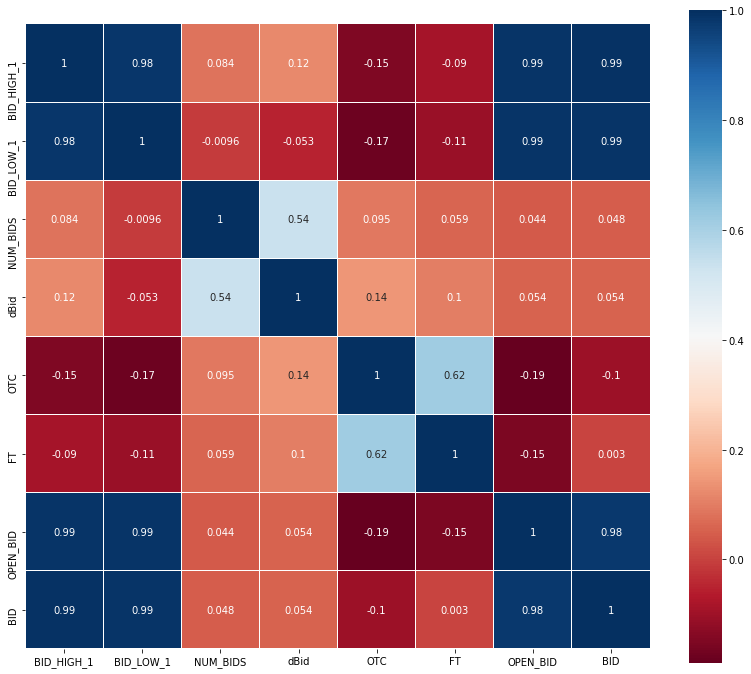

In [ ]:
plt.figure(figsize=(14,12))
sns.heatmap(plottable.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

In [ ]:
# Functions

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)



def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps



def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()



def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Single window of past history : (60, 8)

 Target temperature to predict : (1,)


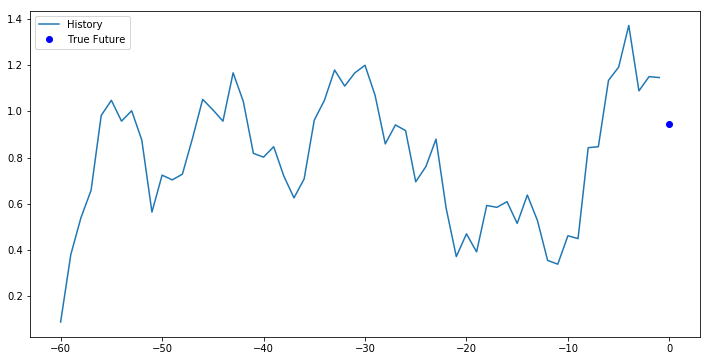

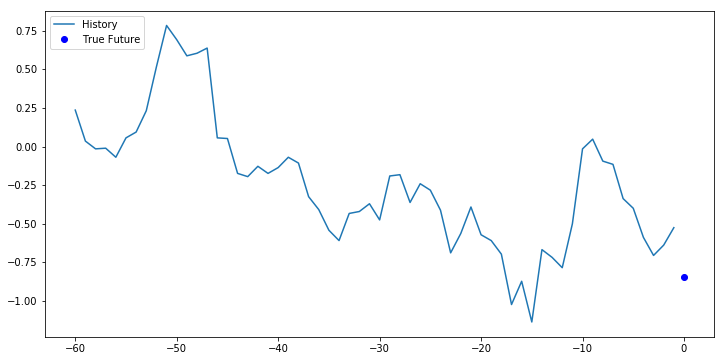

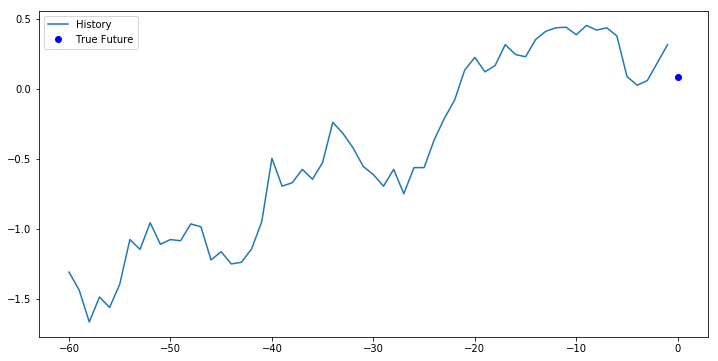

In [ ]:
# Hyperparameters (TODO: Grid Search Tuning， Fix Underfitting)
# 60:20:20 Split
TRAIN_SPLIT=int(0.7*df.shape[0])
# For multivariate_data function
PAST_HISTORY = 60
FUTURE_TARGET = 1
STEP = 1
# For LSTM Model (Don't change this unless we have more data!)
BATCH_SIZE = 20
BUFFER_SIZE = 4096
# For fitting the model
EPOCHS=100
EVALUATION_INTERVAL=100
VALIDATION_STEPS= 50


#Define Variables
x_train_multi = np.zeros(shape=(0,PAST_HISTORY,8))
y_train_multi = np.zeros(shape=(0,FUTURE_TARGET,))
x_val_multi = np.zeros(shape=(0,PAST_HISTORY,8))
y_val_multi = np.zeros(shape=(0,FUTURE_TARGET,))


#NEED HELP: CONCATENATE REPEATABLE DATASETS INSTEAD OF DATASETS
for data in dataset:

    x_train_multi_temp, y_train_multi_temp = multivariate_data(dataset[data], dataset[data][:, 0], 0,
                                                     TRAIN_SPLIT, PAST_HISTORY,
                                                     FUTURE_TARGET, STEP)
    
    x_val_multi_temp, y_val_multi_temp = multivariate_data(dataset[data], dataset[data][:, 0],
                                                 TRAIN_SPLIT, None, PAST_HISTORY,
                                                 FUTURE_TARGET, STEP)
    
    x_train_multi = np.concatenate((x_train_multi, x_train_multi_temp), axis=0)
    y_train_multi = np.concatenate((y_train_multi, y_train_multi_temp), axis=0)
    x_val_multi = np.concatenate((x_val_multi, x_val_multi_temp), axis=0)
    y_val_multi = np.concatenate((y_val_multi, y_val_multi_temp), axis=0)
    
    
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# Generated Samples
for x, y in train_data_multi.take(3):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
#LSTM Model

def make_model(lstm1_nodes, lstm2_nodes, lstm3_nodes, dropout_percentage= 0.5):
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(lstm1_nodes, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
    multi_step_model.add(tf.keras.layers.PReLU())
    multi_step_model.add(tf.keras.layers.Dropout(dropout_percentage))
    multi_step_model.add(tf.keras.layers.LSTM(lstm2_nodes, return_sequences=True))
    multi_step_model.add(tf.keras.layers.PReLU())
    multi_step_model.add(tf.keras.layers.Dropout(dropout_percentage))
    multi_step_model.add(tf.keras.layers.LSTM(lstm3_nodes, activation='relu'))
    multi_step_model.add(tf.keras.layers.Dense(FUTURE_TARGET))

    multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=['accuracy'])
    return multi_step_model

In [ ]:
params= {'lstm1_nodes':[2**x for x in range(1,9)],
         'lstm2_nodes':[2**x for x in range(1,8)],
         'lstm3_nodes':[2**x for x in range(0,7)],
         'dropout_percentage':[0.001, 0.003, 0.01, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
         'batch_size':[10, 20, 40, 60, 80, 100],
         'epochs':[10, 15, 20, 25, 50, 75, 100],
         'steps_per_epoch':[32,64,128,256,512]}

clf = KerasClassifier(make_model)
validator = GridSearchCV(clf,
                         param_grid=params,
                         scoring='neg_mean_absolute_error',
                         n_jobs=1,cv=3)
validator.fit(x_train_multi, y_train_multi)

print('The parameters of the best model are: ')
print(validator.best_params_)

Train on 1133 samples
Epoch 1/10
 310/1133 [=======>......................] - ETA: 3s - loss: 439.8504 - accuracy: 0.0032Train on 1133 samples
Epoch 1/10
 320/1133 [=======>......................] - ETA: 4s - loss: 209.9426 - accuracy: 0.0031Train on 1134 samples
Epoch 1/10
 210/1134 [====>.........................] - ETA: 5s - loss: 204.6719 - accuracy: 0.0000e+00

In [ ]:
# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model
best_model = validator.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(x_test, y_test)
for metric, value in zip(metric_names, metric_values):
    print(metric, ': ', value)

In [ ]:
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
#                                           steps_per_epoch=EVALUATION_INTERVAL,
#                                           validation_data=val_data_multi,
#                                           validation_steps=VALIDATION_STEPS, callbacks=[es])

In [ ]:
# plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

# # Predicted Samples
# for x, y in val_data_multi.take(3):
#   multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])